In [2]:
!pip install -q qiskit>=0.45.0
!pip install qiskit pylatexenc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
!pip install -q qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.4 which is incompatible.


In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

In [5]:
from google.colab import userdata
IBM_API_KEY = userdata.get('API')

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=IBM_API_KEY
)

print(service.backends())

#depriciated
#backend = service.get_backend("ibm_sherbrooke")
backend = service.backend("ibm_brisbane")

<ipython-input-6-1025813121>:3: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(


[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>]


In [7]:
#defining hamiltonian
H = SparsePauliOp.from_list([
    ("XX", 1.0),
    ("YY", 1.0),
    ("ZZ", 1.0)
])
#defining time evolution and defining parameter
from qiskit.circuit import Parameter
t = Parameter("t")
gate = PauliEvolutionGate(H, time=t)

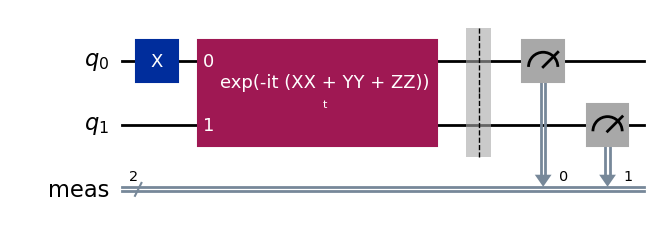

In [9]:
qc = QuantumCircuit(2)
qc.x(0)                      # Prepare |10⟩
qc.append(gate, [0, 1])  # Apply time evolution
qc.measure_all()
qc.draw('mpl')

In [10]:
# Transpile to the ISA circuit for intended backend
backend = service.backend("ibm_brisbane")
qc_meas = transpile(qc, backend)

In [11]:
import numpy as np
# Construct PUB
t_values = np.linspace(0, 3*np.pi, 50)
pub_meas = (qc_meas,t_values)

In [12]:
# Initialize Sampler Primitive and run pub

from qiskit_ibm_runtime import SamplerV2

sampler = SamplerV2(backend)
job_bell_measure = sampler.run([pub_meas], shots = 1024)

/usr/local/lib/python3.11/dist-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


In [ ]:
result_bell_measure = job_bell_measure.result()
data_par_bell_measure = result_bell_measure[0].data
bits = data_par_bell_measure.meas

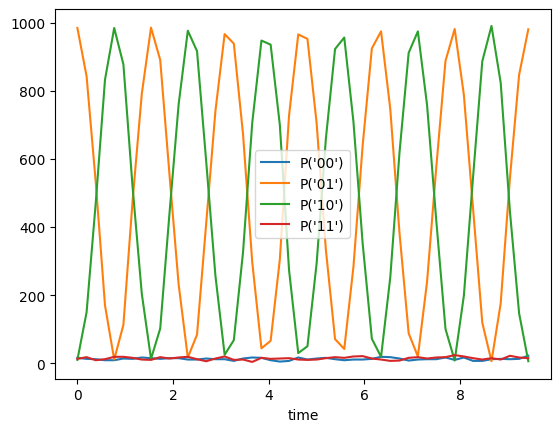

In [ ]:
#plotting time evolution
import matplotlib.pyplot as plt
import seaborn
p00=np.sum(bits.array==0, axis=1)
p01=np.sum(bits.array==1, axis=1)
p10=np.sum(bits.array==2, axis=1)
p11=np.sum(bits.array==3, axis=1)

plt.plot(t_values,p00,label="P('00')")
plt.plot(t_values,p01,label="P('01')")
plt.plot(t_values,p10,label="P('10')")
plt.plot(t_values,p11,label="P('11')")
plt.xlabel("time")
plt.legend()
plt.show()

NOTE- The bits are invereted and hence, we expect to see only 01 and 10 states but rest are present to some extent due to a bit of noise in the backend.

**3 spin state**

In [13]:
#defining hamiltonian
H1 = SparsePauliOp.from_list([
    ("XXI", 1.0),("YYI", 1.0),("ZZI", 1.0), #interactions betweem qbit 0 and 1
    ("YIY", 1.0),("ZIZ", 1.0),("XIX", 1.0), #interactions betweem qbit 0 and 2
    ("IXX", 1.0),("IYY", 1.0),("IZZ", 1.0)  #interactions between qbit 1 and 2
])
#defining time evolution and defining parameter
from qiskit.circuit import Parameter
t = Parameter("t")
gate1 = PauliEvolutionGate(H1, time=t)

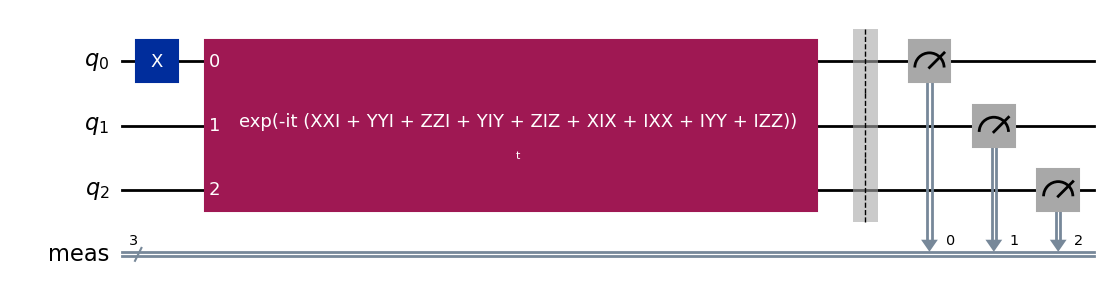

In [14]:
qc1 = QuantumCircuit(3)
qc1.x(0)
qc1.append(gate1, [0, 1, 2])  # Apply time evolution
qc1.measure_all()
qc1.draw('mpl')

In [15]:
#transpilation and PUB
qc1_meas=transpile(qc1, backend)
pub1_meas = (qc1_meas,t_values)

In [16]:
job_bell_measure1 = sampler.run([pub1_meas], shots = 1024)

In [17]:
result_bell_measure1 = job_bell_measure1.result()
data_par_bell_measure1 = result_bell_measure1[0].data
bits1 = data_par_bell_measure1.meas

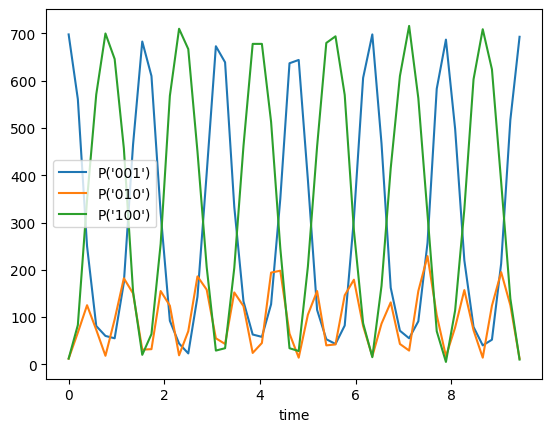

In [20]:
#plotting time evolution
p000=np.sum(bits1.array==0, axis=1)
p001=np.sum(bits1.array==1, axis=1)
p010=np.sum(bits1.array==2, axis=1)
p011=np.sum(bits1.array==3, axis=1)
p100=np.sum(bits1.array==4, axis=1)
p101=np.sum(bits1.array==5, axis=1)
p110=np.sum(bits1.array==6, axis=1)
p111=np.sum(bits1.array==7, axis=1)

#plt.plot(t_values,p000,label="P('000')")
plt.plot(t_values,p001,label="P('001')")
plt.plot(t_values,p010,label="P('010')")
#plt.plot(t_values,p011,label="P('011')")
plt.plot(t_values,p100,label="P('100')")
#plt.plot(t_values,p101,label="P('101')")
#plt.plot(t_values,p110,label="P('110')")
#plt.plot(t_values,p111,label="P('111')")
plt.xlabel("time")
plt.legend()
plt.show()

The hilbert space for the final outputs for the first case is of dim. 4 while of 8 in 3 state systems

For first case hamioltonian equals (X<sub>0</sub>X<sub>1</sub>+Y<sub>0</sub>Y<sub>1</sub>+Z<sub>0</sub>Z<sub>1</sub>) while for 3 state systems
(X<sub>0</sub>X<sub>1</sub>X<sub>2</sub>+Y<sub>0</sub>Y<sub>1</sub>Y<sub>2</sub>+Z<sub>0</sub>Z<sub>1</sub>Z<sub>2</sub>)

The hamiltonian function conserevs the number of 0s and the number of 1s in the system and so will time evolution as it coomutes with Z. So the states observed in two state system will be 01 and 10 only while in three state system only 001, 010 and 100 are observed. The noise observed is higher in three state systems.